In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import glob
import random
%matplotlib inline

In [2]:
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
img_path = glob.glob("d:/datasets/lakeplane/*/*.jpg")

In [4]:
len(img_path)

1400

In [5]:
img_path[:5],img_path[-5:]

(['d:/datasets/lakeplane\\airplane\\airplane_001.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_002.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_003.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_004.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_005.jpg'],
 ['d:/datasets/lakeplane\\lake\\lake_696.jpg',
  'd:/datasets/lakeplane\\lake\\lake_697.jpg',
  'd:/datasets/lakeplane\\lake\\lake_698.jpg',
  'd:/datasets/lakeplane\\lake\\lake_699.jpg',
  'd:/datasets/lakeplane\\lake\\lake_700.jpg'])

In [6]:
random.shuffle(img_path)

In [7]:
img_path[:5],img_path[-5:]

(['d:/datasets/lakeplane\\lake\\lake_622.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_060.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_494.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_248.jpg',
  'd:/datasets/lakeplane\\lake\\lake_024.jpg'],
 ['d:/datasets/lakeplane\\lake\\lake_440.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_236.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_660.jpg',
  'd:/datasets/lakeplane\\airplane\\airplane_595.jpg',
  'd:/datasets/lakeplane\\lake\\lake_130.jpg'])

In [8]:
all_image_labels = [int(p.split('\\')[1]=="lake")for p in img_path]

In [9]:
all_image_labels[:5],all_image_labels[-5:]

([1, 0, 0, 0, 1], [1, 0, 0, 0, 1])

In [10]:
# 定义函数读取、解码图片
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image,tf.float32)
    image = image/255.0
    return image

52 airplane


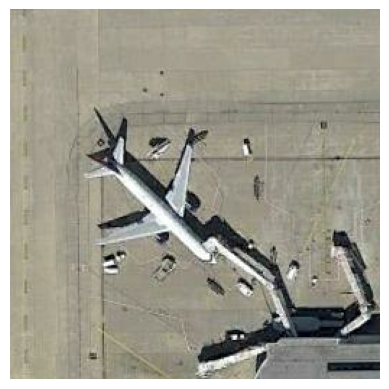

In [11]:
# 随机选取图片显示，并输出标签
rr = random.randint(0,len(img_path))
img_path_ = img_path[rr]
plt.imshow(load_and_preprocess_image(img_path_))
plt.axis("off")
print(rr,np.where(all_image_labels[rr]==1,"lake","airplane"))

In [12]:
train_val_count = int(len(img_path)*.85)
train_val_img_path = tf.data.Dataset.from_tensor_slices(img_path[:train_val_count])
test_img_path = tf.data.Dataset.from_tensor_slices(img_path[train_val_count:])

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_val_image_ds = train_val_img_path.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

In [14]:
test_image_ds = test_img_path.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

In [15]:
train_val_label = tf.data.Dataset.from_tensor_slices(
    all_image_labels[:train_val_count])
test_label = all_image_labels[train_val_count:]

In [16]:
train_val_image_label_ds = tf.data.Dataset.zip((
    train_val_image_ds,train_val_label))

In [17]:
val_count = int(train_val_count*0.2)
train_count = train_val_count-val_count

In [18]:
val_count,train_count

(238, 952)

In [42]:
val_image_label_ds = train_val_image_label_ds.take(val_count)
train_image_label_ds = train_val_image_label_ds.skip(val_count)

In [43]:
train_image_label_ds,val_image_label_ds,test_image_ds

(<SkipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>)

In [44]:
BATCH_SIZE = 32

In [45]:
train_data_r = train_image_label_ds.repeat()
train_data_r_b = train_data_r.batch(BATCH_SIZE)
train_data = train_data_r_b.prefetch(AUTOTUNE)

In [46]:
val_data = val_image_label_ds.batch(BATCH_SIZE)
test_data = test_image_ds.batch(BATCH_SIZE)

In [47]:
train_data,val_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>)

In [48]:
# 建立模型
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3),input_shape=(256,256,3),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_2   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,113
Trainable params: 2,049
Non-traina

In [50]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

In [51]:
steps_per_epoch = train_count//BATCH_SIZE

In [52]:
steps_per_epoch

29

In [53]:
print(train_data)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [55]:
# history = model.fit(train_data,epochs=3,
#                     steps_per_epoch=steps_per_epoch,
#                     validation_data=val_data)
history = model.fit(train_data, epochs=30, steps_per_epoch=steps_per_epoch, 
                    validation_data=val_data)

Epoch 1/30
29/29 [==============================] - 21s 714ms/step - loss: 0.4787 - acc: 0.8481 - val_loss: 0.6426 - val_acc: 0.5336
Epoch 2/30
29/29 [==============================] - 19s 667ms/step - loss: 0.3527 - acc: 0.8384 - val_loss: 0.5961 - val_acc: 0.7941
Epoch 3/30
29/29 [==============================] - 19s 660ms/step - loss: 0.3050 - acc: 0.8653 - val_loss: 0.5506 - val_acc: 0.8571
Epoch 4/30
29/29 [==============================] - 19s 660ms/step - loss: 0.2721 - acc: 0.8912 - val_loss: 0.5164 - val_acc: 0.8782
Epoch 5/30
29/29 [==============================] - 19s 661ms/step - loss: 0.2363 - acc: 0.9256 - val_loss: 0.4843 - val_acc: 0.8824
Epoch 6/30
29/29 [==============================] - 19s 661ms/step - loss: 0.1990 - acc: 0.9483 - val_loss: 0.4376 - val_acc: 0.8908
Epoch 7/30
29/29 [==============================] - 19s 669ms/step - loss: 0.1734 - acc: 0.9483 - val_loss: 0.3982 - val_acc: 0.8908
Epoch 8/30
29/29 [==============================] - 19s 668ms/step - 

In [56]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

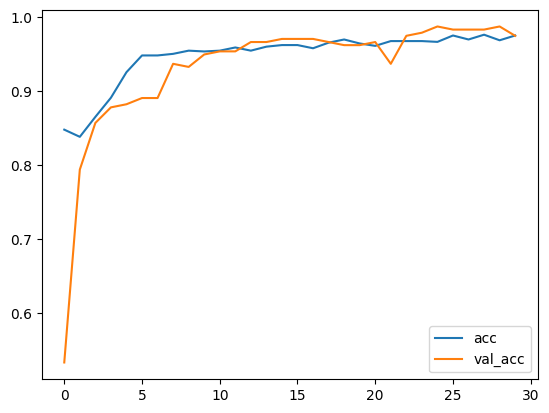

In [57]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')
plt.legend()

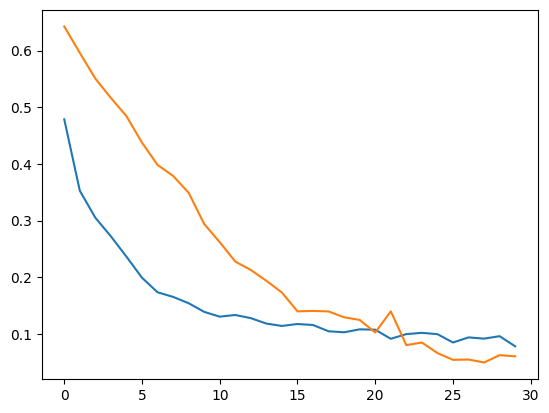

In [61]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')

In [62]:
pred_prob = model.predict(test_data)

7/7 [==============================] - 2s 260ms/step


In [65]:
pred_prob = [int(i>0.5) for i in pred_prob]

In [67]:
print(classification_report(test_label,pred_prob))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       105
           1       1.00      0.88      0.93       105

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210

